In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random

def date_parser(s):
    """
    Parse a date string using the log file's format. For example: '2015/10/16 11:25:59.000'
    """
    without_ms = s.split('.')[0]
    return datetime.datetime.strptime(without_ms, '%Y/%m/%d %H:%M:%S')

log = pd.read_csv('data/log.csv', parse_dates=['startTime', 'completeTime'], date_parser=date_parser)
log.head()

,case,event,startTime,completeTime,agecategory,office_w,NumberWerkMapMessages,office_u,NumberComplaints,gender,...,questiontopicid,questionsubthemeid,event_office_w,tip_en,service_detail,ipid,event_office_u,questiontheme_en,complainttopic_en,service_detail_en
0,1445,NaN,2015-08-07 10:51:41,2015-08-07 10:51:41,30-39,291,0,296,0,M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1445,Visit page mijn_cv,2015-08-07 10:52:27,2015-08-07 10:52:27,30-39,291,0,296,0,M,...,NaN,NaN,291.0,NaN,NaN,1048748.0,296.0,NaN,NaN,NaN
2,1445,Visit page home,2015-08-07 10:53:08,2015-08-07 10:53:08,30-39,291,0,296,0,M,...,NaN,NaN,291.0,NaN,NaN,1048748.0,296.0,NaN,NaN,NaN
3,1445,Visit page mijn_cv,2015-08-07 10:53:14,2015-08-07 10:53:14,30-39,291,0,296,0,M,...,NaN,NaN,291.0,NaN,NaN,1048748.0,296.0,NaN,NaN,NaN
4,1445,Visit page home,2015-08-07 10:53:38,2015-08-15 19:05:12,30-39,291,0,296,0,M,...,NaN,NaN,291.0,NaN,NaN,1048748.0,296.0,NaN,NaN,NaN


<h2>  Data Quality </h2>

Lets start by checking the NaN counts. Are there columns with many missing values?

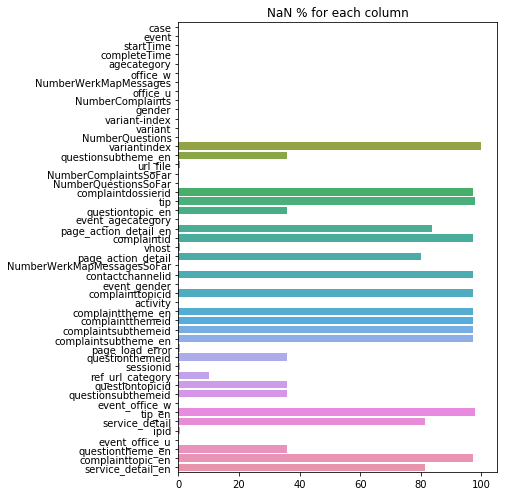

In [2]:
null = log.isnull().sum() * 100 / len(log)
null.head()

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(5.7, 8.27)

sns.barplot(x=null, y=null.index).set_title('NaN % for each column')
plt.show()

In [3]:
import missingno as msno
msno.heatmap(log)

ModuleNotFoundError: No module named 'missingno'

<h3> Missing value conditional probability </h3>

The heatmap above shows features that tend to either existing or missing together. Nullity correlation ranges from -1 (if one variable appears the other definitely does not) to 0 (variables appearing or not appearing have no effect on one another) to 1 (if one variable appears the other definitely also does).

<h2> Unique values </h2>

Lets now look at the distribution of unique values in each column. This can provide an insight into their meaning.

In [6]:
log.apply(pd.Series.nunique)

case                            4226
event                            246
startTime                     481325
completeTime                  481324
agecategory                        4
office_w                          40
NumberWerkMapMessages             37
office_u                          13
NumberComplaints                   6
gender                             2
variant-index                   4224
variant                         4225
NumberQuestions                   40
variantindex                       1
questionsubtheme_en              133
url_file                         355
NumberComplaintsSoFar              6
NumberQuestionsSoFar              50
complaintdossierid               256
tip                               29
questiontopic_en                 772
event_agecategory                  4
page_action_detail_en             20
complaintid                      289
vhost                              2
page_action_detail               214
NumberWerkMapMessagesSoFar        54
c

<b> Some of these numbers are interesting. Specifically the following conclusions can be drawn: </b>

- The case column refers to the signed in users. There are **4226 unique users** in our database


- The sessionid refers to the internet session. There are **106221 different sessions**, therefore each user visited our site **25 times on average** 


- There are **246 different events**  (all of them referring to specific URL visits). This info is recorded twice (**activity and event columns seem to be the same**). We can therefore safely remove one of them.


- Ages are binned into **4 categories** , probably for anonimization purposes.

<h3> Lets look with some more detail into the different values for interesting features </h3>

In [ ]:
# Events without an event type are pretty useless so we might as well drop them
log.dropna(axis=0, subset=['event'], inplace=True)

events = log['event'].unique()
not_page_visits = [event for event in events if not event.startswith('Visit page')]
not_page_visits

<h3> Almost all events are page visits! </h3>

As we can see, out of 246 unique events, 243 are visits of specific URL pages. The 3 remaining are very important for our case since we are mostly interested in traces that lead to a call, a question or a complaint. 

<b> Lets take a closer look at this events. </b>

In [ ]:
def event_percentage(event):
    return len(log.loc[log['event'] == event]) * 100 / len(log)

for event in not_page_visits:
    print('{:.2f}% of records refer to a {}'.format(event_percentage(event), event))

In [ ]:
complain_cols = [c for c in log.columns if 'complaint' in c] 
question_cols = [c for c in log.columns if 'question' in c]

<h2> Filtering interesting traces </h2>

We are mostly interested in traces that conclude or include at least one instance of a "slow" channel. This could be a question asked to the call center, a discussion initiated on the website (identified by the presence of WerkMap messages) or a cimplaint filed. We can achieve that by first moving to a trace representation and then filtering accordingly.

In [ ]:
log.head()

In [7]:
# Make sure the list of activities per session will be ordered by time
log.sort_values(['sessionid', 'startTime'], ascending=[True, True], inplace=True)

# Define aggregations when looking at each session
aggregations = {'event': lambda x: list(x), 
                'startTime': 'first', 
                'completeTime': 'last', 
                'gender': 'first'
               }
sessions = log.groupby('sessionid', as_index=False).agg(aggregations)
sessions.head()

,sessionid,event,startTime,completeTime,gender
0,92.0,"[Visit page mijn_werkmap, Question]",2015-10-14 14:59:37,2015-10-16 11:25:59,M
1,358.0,"[Visit page mijn_berichten, Visit page taken, ...",2015-10-15 13:34:42,2015-10-15 13:54:38,V
2,447.0,"[Visit page mijn_berichten, Werkmap message]",2015-10-07 11:37:32,2015-10-07 11:44:35,M
3,1117.0,"[Visit page home, Visit page taken, Visit page...",2015-10-30 14:28:33,2015-11-02 10:16:02,V
4,1472.0,"[Visit page mijn_cv, Visit page mijn_werkmap, ...",2015-10-09 10:37:38,2015-10-09 11:00:31,V


<h2> Throughtput </h2>

It is interesting to check the distribution of time spent during each session and perhaps relate it to other session atributes, like demographics etc. We define a session's duration as the time spent between the start of its first event and the complete of its last event.

In [8]:
sessions['duration'] = sessions['completeTime'] - sessions['startTime']

def compute_average(durations):
    """
    Compute the average from a (potentially long) iterable of timedeltas.
    """
    size = len(durations)
    zero = datetime.timedelta(0)
    try:
        return sum(durations, zero) / len(durations)
    except OverflowError:
        print("Duration list too big, processing in chunks")
        return sum(durations[0:50000], zero) / size + sum(durations[50000: ], zero) / size
                
average_duration = compute_average(sessions['duration'])
average_duration

Duration list too big, processing in chunks


Timedelta('1 days 14:30:11.567816')

In [9]:
sessions['sessionid'].isnull().sum()

0

In [10]:
def filter_traces(df, *events, include=True):
    """
    Only keep traces that include or exclude at least one of the events passed
    """
    def any_in(a, b):
        if include:
            return any(i in a for i in b)
        return all(i not in a for i in b)
    
    return df[df['event'].apply(any_in, args=(events,))]
        
def conditional_average(*events, include=True):
    subset = filter_traces(sessions, *events, include=include)
    return compute_average(subset['duration'])

def to_log(session_df):
    """
    Translate the session view back to the original format
    """
    session_set = session_df['sessionid'].unique()
    return log[log['sessionid'].isin(session_set)]
    
sad_events = ['Question', 'Werkmap message', 'Complaint']
bad_path_avg = conditional_average(*sad_events, include=True)
print('Traces that include slow communication take {} on average'.format(bad_path_avg))

happy_path_avg = conditional_average(*sad_events, include=False)
print('Traces that do NOT include slow communication take {} on average'.format(happy_path_avg))

Traces that include slow communication take 5 days 00:33:28.845784 on average
Traces that do NOT include slow communication take 0 days 21:50:50.918503 on average


In [11]:
# Lets filter our initial dataset. These are the different ways to do it:

# 1. Just provide a single event to be included or excluded
test = filter_traces(sessions, 'Question', include=False) # Only traces without a question will be included

# 2. Provide multiple events to be included or excluded
test = filter_traces(sessions, 'Question', 'File Complaint', include=True) # Only traces with a question or a complaint

# 3. Provide a list of events to be included or excluded
sad_events = ['Question', 'Werkmap message', 'File Complaint']
happy_paths = filter_traces(sessions, *sad_events, include=False) # Only happy paths will be included
sad_paths = filter_traces(sessions, *sad_events, include=True) # Only unhappy paths will be included

# Get a subset back to the original customerID based format
happy_log = to_log(happy_paths)
happy_log.to_csv('data/happy_log.csv',index=False)
sad_log = to_log(sad_paths)
sad_log.to_csv('data/sad_log.csv',index=False)

# Create subsets of happy and sad path (Santiago)
We select 30 % of the cases in the sad path and 10% of the cases on happy path




In [12]:
def create_sub_set(x,por):
    """
    Subsample of the number of cases to model.
    """
    random.seed(3)
    name_cases = x['case'].unique()
    n = int(len(name_cases)*por)
    indices = np.random.permutation(name_cases.shape[0])
    training_idx, test_idx = indices[:n], indices[n:]
    training_idx, test_idx = name_cases[training_idx], name_cases[test_idx]
    
    training = x[x['case'].isin(training_idx)]
    test = x[x['case'].isin(test_idx)]
    print('The initail number of cases is {} '.format(len(name_cases)))
    print('The number of cases selected is  {} '.format(training_idx.shape[0]))

    return training
    

create_sub_set(happy_log.copy(),0.05).to_csv('data/happy_log_subsample.csv',index=False)
create_sub_set(sad_log.copy(),0.05).to_csv('data/sad_log_subsample.csv',index=False)


The initail number of cases is 4072 
The number of cases selected is  203 
The initail number of cases is 3772 
The number of cases selected is  188 


# Impute Question as desagregated activity

In [9]:
df_sad = pd.read_excel('C:/Users/s157084/Google Drive/Projects Process Mining/Data/paths_taxonomy/sad_with_taxonomy.xlsx')
#df_sad = pd.read_csv('C:/Users/s157084/Google Drive/Projects Process Mining/Data/paths_taxonomy/sad_with_taxonomy.csv')1

In [23]:
def impute_question(df):
    
    df['domain_level_1'][df['event'] == 'Question'] = df['domain_level_1'][df['event'] == 'Question'] + '/Question'
    df['domain_level_2'][df['event'] == 'Question'] = df['domain_level_2'][df['event'] == 'Question'] + '/Question'
    df['domain_level_2'][df['event'] == 'Question'] = df['domain_level_2'][df['event'] == 'Question'] + '/Question'
    
    
    return df

df_sad_imp = impute_question(df_sad.copy())
df_sad_imp.to_csv('C:/Users/s157084/Google Drive/Projects Process Mining/Data/paths_taxonomy/sad_with_taxonomy_Question.csv',index=False)

C:\Users\s157084\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\s157084\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\s157084\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

In [20]:
df_sad_imp['domain_level_1'].unique()

array(['/werk_nl/werknemer/', '/werk_nl/werknemer/Question',
       '/printservice/print/', '/portal/page/', '/shared/timeout.htm/',
       '/shared/foutopgetreden.html/', '/ewerkmap/readdetails/',
       '/werk_nl/fout/', '/werk_nl/ignore_request_page/',
       '/zoeken_portlet/ajax/', '/queueit/healthcheck/',
       '/portal/page/Question', '/werk_nl/werkgever/', '/portal/pls/',
       '/ajax/dwr/', 'Missing/', 'Missing/Question',
       '/werk_nl/ignore_request_page/Question', '/ewerkmap/document/',
       '/werk_nl/werkgever/Question',
       '/shared/foutopgetreden.html/Question', '/werk_nl/eures/',
       '/werk_nl/melding_account_afmelden/', '/portal/pls/Question',
       '/werk_nl/arbeidsmarktinformatie/', '/shared/timeout.htm/Question',
       '/werk_nl/arbeidsmarktinformatie/Question',
       '/werk_nl/fout/Question', '/printservice/print/Question',
       '/ajax/dwr/Question', '/ewerkmap/document/Question',
       '/shared/onderhoud.htm/', '//werk_nl/',
       '/shared/onder

<h2> Are certain demographic groups more probable to use slow communication channels? </h2>

In [ ]:
len(question_sessions[question_sessions['gender'] == 'V']) / len(question_sessions) # Hint: Not really :P